In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyOffsetFrame, ICRS, ITRS
import numpy as np

from h5parm import DataPack
from enu import ENU

2023-01-24 19:56:41,733 Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-01-24 19:56:41,734 NumExpr defaulting to 8 threads.


Josh's description of the screens

Phase conversion factor:
TEC_CONV = -8.4479745  # mTECU/MHz
phase = tec * TEC_CONV/freq_MHz

Params
Datetime: 2019-03-19T19:58:14.9-20:13:14.9
FOV: a 10.8deg diameter gives the 20% power point at the lowest frequency
Time resolution: I'm currently doing 1-min. The planned integration time is 1.5s. You can give me anything that makes sense to you,
00h00m0.0s +37.07.47.400s

# IO stuff

In [2]:
from enu import ENU


def find_center(ants, times_grid):
    ref_ant = ants[0]
    f = ENU(location=ref_ant.earth_location, obstime=times_grid[0])
    ants_enu = ITRS(*ants.cartesian.xyz, obstime=times_grid[0]).transform_to(f)
    mean_x = np.median(ants_enu.east.value)
    mean_y = np.median(ants_enu.north.value)
    print(mean_x, mean_y)
    ref_ind = np.argmin((ants_enu.east.value - mean_x)**2 + (ants_enu.north.value - mean_y)**2)
    print(ref_ind)
    return ref_ind

def get_tec_grid():
    with DataPack('/fastpool/yuping/dsa2000W_datapack_1000m_single_timestep.h5', readonly=True) as dp:
        dp.current_solset = 'sol000'
        dp.select(pol=slice(0, 1, 1))
        tec_grid, axes = dp.tec #order=[pol,dir,ant,time]
        tec_grid = tec_grid[0]
        patch_names, directions_grid = dp.get_directions(axes['dir'])
        antenna_labels, antennas_grid = dp.get_antennas(axes['ant'])
        timestamps, times_grid = dp.get_times(axes['time'])
    phase_center = SkyCoord(ra='00h00m0.0s', dec='+37d07m47.400s')
    offsets = directions_grid.transform_to(SkyOffsetFrame(origin=phase_center))
    ref_ind = find_center(antennas_grid, times_grid)
    frame = ENU(location=antennas_grid[ref_ind].earth_location, obstime=times_grid[0])
    antennas_grid_enu = ITRS(*antennas_grid.cartesian.xyz, obstime=times_grid[0]).transform_to(frame)
    return tec_grid, antennas_grid_enu, offsets

In [3]:
tec_grid, antennas_grid_enu, offsets = get_tec_grid()

2023-01-24 19:56:52,521 Set current solset to: sol000
2023-01-24 19:56:52,523 Set current solset to: sol000


8756.913924420745 1228.00018677122
180


(array([  631.,  4815., 13223., 23160., 24781., 17769., 14074.,  7615.,
         1778.,   184.]),
 array([-47.16054227, -36.54404361, -25.92754496, -15.3110463 ,
         -4.69454764,   5.92195102,  16.53844968,  27.15494834,
         37.771447  ,  48.38794566,  59.00444432]),
 <BarContainer object of 10 artists>)

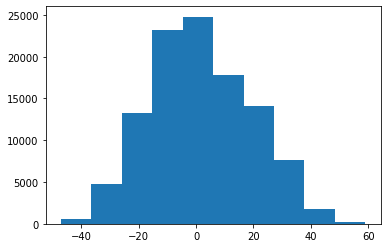

In [5]:
plt.hist(tec_grid.flatten())

NameError: name 'antennas_grid' is not defined

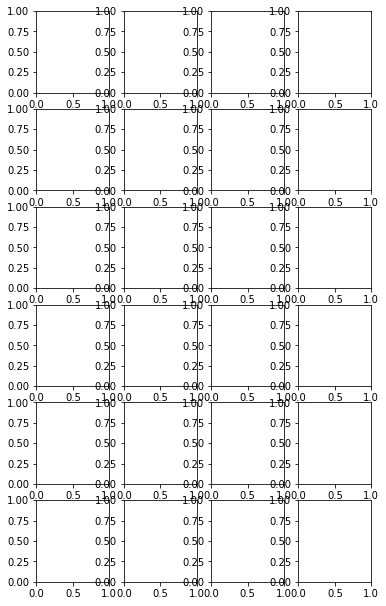

In [6]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

cs = Normalize(vmin=-40, vmax=40)
with PdfPages('per_direction.pdf') as pdf:
    for pp in range(tec_grid.shape[0] // 24 + 1):
        fig, axs = plt.subplots(6, 4, figsize=(6, 10.5))
        for i, ax in enumerate(axs.flatten()):
            patch = 24 * pp + i
            if patch > 276:
                break
            data = tec_grid[patch, :, 0]
            s = ax.scatter(antennas_grid.east/1e3, antennas_grid.north/1e3, s=2, c=data, norm=cs)
            ax.set_aspect(1)
            ax.set_title(f'{patch_names[patch]}, '
                         f'Delta={(np.max(data) - np.min(data)):.1f} '
                         f'std={(np.std(data)):.1f}', fontsize=3)
            ax.tick_params(axis='both', which='major', labelsize=3)
        cbar = fig.colorbar(s, ax=axs[-1,:], location='bottom', shrink=0.8)
        cbar.ax.tick_params(labelsize=5) 
        fig.suptitle('mTEC per direction over array')
        pdf.savefig()
        plt.close()

In [108]:
with PdfPages('per_ant.pdf') as pdf:
    for pp in range(tec_grid.shape[0] // 24 + 1):
        fig, axs = plt.subplots(6, 4, figsize=(6, 10.5))
        for i, ax in enumerate(axs.flatten()):
            ant = 24 * pp + i
            if ant > 389:
                break
            data = tec_grid[:, ant, 0]
            s = ax.scatter(offsets.lon, offsets.lat, s=2, c=data, norm=cs)
            ax.set_title(f'{antenna_labels[ant]}, '
                         f'Delta={(np.max(data) - np.min(data)):.1f} '
                         f'std={(np.std(data)):.1f}', fontsize=3)
            ax.tick_params(axis='both', which='major', labelsize=3)
        cbar = fig.colorbar(s, ax=axs[-1,:], location='bottom', shrink=0.8)
        cbar.ax.tick_params(labelsize=5) 
        fig.suptitle('mTEC per antenna over sky')
        pdf.savefig()
        plt.close()

Question: how much does the iono move (say with TIDS). 200km/h over 15 min is 50 km.

Need to figure out two things for single source sims:

- How to go from the screen to phase? i.e. should I be simulating a directional differential screen? What's the time structure of the phase? i.e. how do I simulate some post-calibration data?
- How does a single source simulation translate to how many fields will be problematic for us? I think we can just extend the MC simulation that Tyrone did and answer this question, or do it for all planned pointings. 


## Interpolate onto antennas

In [4]:
actual_ants = np.loadtxt('/home/yuping/frank/20210326-configs/20210226W.txt', usecols=(0,1))

In [5]:
from scipy.interpolate import griddata

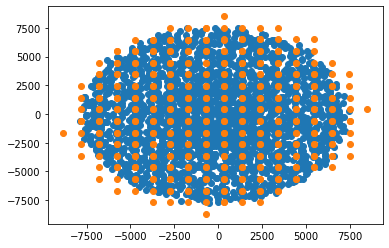

In [6]:
plt.scatter(actual_ants[:,0], actual_ants[:,1])
plt.scatter(antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
            antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value)))

In [6]:
tec_screens = griddata((antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
                        antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value))),
                       np.swapaxes(tec_grid, 0, 1),
                       actual_ants, method='linear')

In [7]:
np.any(np.isnan(tec_screens))

False

In [8]:
np.max(tec_screens), np.min(tec_screens)

(56.196021591534546, -46.68603332095727)

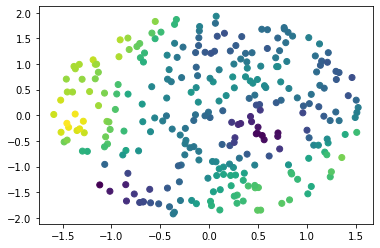

In [10]:
plt.scatter(offsets.lon, offsets.lat, c=tec_screens[0])

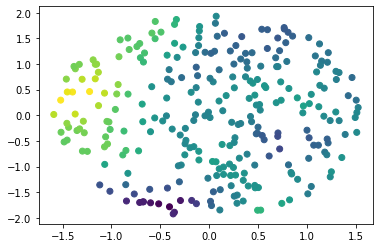

In [11]:
plt.scatter(offsets.lon, offsets.lat, c=tec_screens[1004])

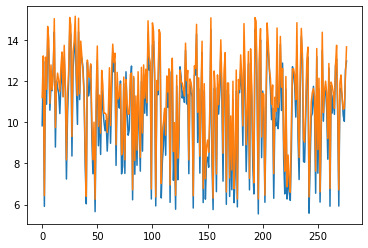

In [262]:
plt.plot(np.std(tec_screens, axis=0)[:,0])
plt.plot(np.std(tec_grid, axis=1)[:,0])

In [12]:
np.argmax(np.std(tec_screens, axis=0)[:,0])

30

In [13]:
tec_screens[:,30,0]

array([16.33529866, 18.85477131, 20.13002968, ...,  1.97871816,
        1.29894574,  2.36395504])

In [9]:
TEC_CONV = -8.4479745  # mTECU/MHz

In [12]:
freq_arr = (np.arange(8000) * 162.5e3) + 0.7e9
iono_gains = np.exp(1j * tec_screens[:,30, None, None] * (TEC_CONV * 1e6 /freq_arr)[None, :, None, None]) * np.identity(2)

In [24]:
np.std(np.angle(iono_gains[0,:,0,0], deg=True))

1.9712922235989017

(array([[ 107.,   82.,  242.,  466.,  329.,  217.,  256.,  198.,  117.,
           34.],
        [   0.,    0.,    0.,    0.,    0.,    0., 2048.,    0.,    0.,
            0.]]),
 array([-0.48913961, -0.40825438, -0.32736915, -0.24648393, -0.1655987 ,
        -0.08471348, -0.00382825,  0.07705697,  0.1579422 ,  0.23882742,
         0.31971265]),
 <a list of 2 BarContainer objects>)

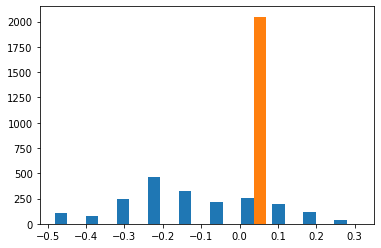

In [24]:
plt.hist(np.angle(iono_gains[:, 0, 0]))

(array([107.,  82., 242., 466., 329., 217., 256., 198., 117.,  34.]),
 array([-0.22637866, -0.18894418, -0.15150969, -0.11407521, -0.07664072,
        -0.03920624, -0.00177175,  0.03566273,  0.07309722,  0.1105317 ,
         0.14796618]),
 <BarContainer object of 10 artists>)

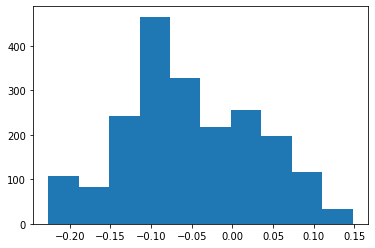

In [297]:
plt.hist(np.angle(iono_gains[:, 5000, 0]))

(array([107.,  82., 242., 466., 329., 217., 256., 198., 117.,  34.]),
 array([-0.17121277, -0.14290064, -0.11458851, -0.08627639, -0.05796426,
        -0.02965213, -0.00134   ,  0.02697213,  0.05528426,  0.08359639,
         0.11190852]),
 <BarContainer object of 10 artists>)

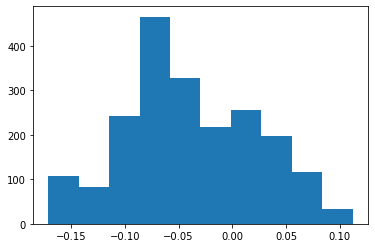

In [298]:
plt.hist(np.angle(iono_gains[:, 7999, 0]))

In [14]:
iono_gains = iono_gains[np.newaxis,:]

In [11]:
iono_gains.shape

(1, 2048, 8000, 2, 2)

In [19]:
iono_gains[0,0,0]

array([[0.98063015-0.19586859j, 0.        +0.j        ],
       [0.        +0.j        , 0.98063015-0.19586859j]])

In [12]:
import dftsource

In [17]:
from importlib import reload
reload(dftsource)

<module 'dftsource' from '/home/yuping/sim-toolkit/notebooks/dftsource.py'>

In [13]:
import dask.array as da
dftsource.point_src_with_gain(iono_gains, '/fastpool/data/gh/W-snapshot-8000chan-iono-1-5s-noise.ms', rms=0.366268*np.sqrt(900/1.5))

[########################################] | 100% Completed |  9hr 33min 43.0s


In [14]:
iono_gains[:,:,::10,:,:].shape

(1, 2048, 800, 2, 2)

In [13]:
iono_gains[:,:,[-1],:,:].shape

(1, 2048, 1, 2, 2)

In [14]:
dftsource.point_src_with_gain(iono_gains[:,:,[-1],:,:], '/fastpool/data/W-1chan.ms', rms=0.366268*np.sqrt(900/1.5)/np.sqrt(10))

2096128
[########################################] | 100% Completed | 28.5s


In [15]:
iono_gains[:,:,[-1],:,:].shape

(1, 2048, 1, 2, 2)

# Compare against CASA bandpass

In [15]:
ans = np.angle(iono_gains[0,:,-1,0, 0])

In [16]:
ans = ans - ans[0]

In [24]:
with table('/fastpool/data/W-1chan.bcal') as t:
    solved = t.getcol('CPARAM')

Successful readonly open of default-locked table /fastpool/data/W-1chan.bcal: 13 columns, 2048 rows


Text(0.5, 0, 'Antenna Number')

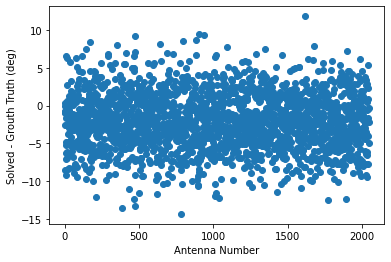

In [43]:
plt.plot((np.angle(solved[:, 0, 0]) - ans) * 57.2958, linestyle='None', marker='o')
plt.ylabel('Solved - Grouth Truth (deg)')
plt.xlabel('Antenna Number')

Text(0.5, 0, 'Offset from center (km)')

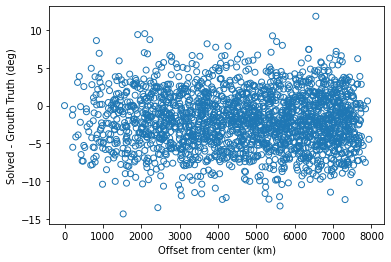

In [41]:
plt.scatter(np.sqrt(actual_ants[:,0]**2 + actual_ants[:,1]**2), (np.angle(solved[:, 0, 0]) - ans) * 57.2958, marker='o',  facecolors='none', edgecolors='C0')
plt.ylabel('Solved - Grouth Truth (deg)')
plt.xlabel('Offset from center (km)')

Text(0.5, 0, 'Offset from center (m)')

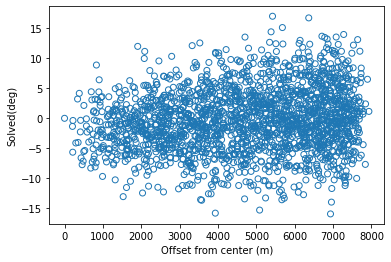

In [46]:
plt.scatter(np.sqrt(actual_ants[:,0]**2 + actual_ants[:,1]**2), (np.angle(solved[:, 0, 0])) * 57.2958, marker='o',  facecolors='none', edgecolors='C0')
plt.ylabel('Solved(deg)')
plt.xlabel('Offset from center (m)')

Text(0.5, 0, 'Offset from center (m)')

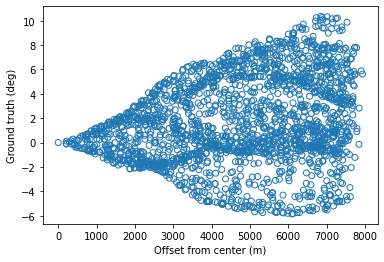

In [48]:
plt.scatter(np.sqrt(actual_ants[:,0]**2 + actual_ants[:,1]**2), ans * 57.2958, marker='o',  facecolors='none', edgecolors='C0')
plt.ylabel('Ground truth (deg)')
plt.xlabel('Offset from center (m)')

In [47]:
resid = (np.angle(solved[:, 0, 0]) - ans) * 57.2958
print(np.mean(resid))
print(np.std(resid))

-2.033632285283824
3.7101915720266097


(array([  9.,  46., 183., 409., 569., 452., 283.,  72.,  21.,   4.]),
 array([-12.33239132,  -9.71063279,  -7.08887426,  -4.46711573,
         -1.8453572 ,   0.77640133,   3.39815986,   6.01991838,
          8.64167691,  11.26343544,  13.88519397]),
 <BarContainer object of 10 artists>)

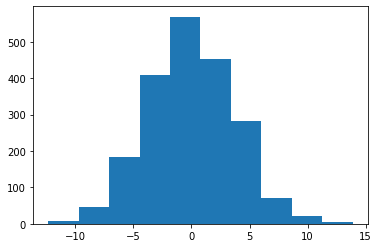

In [50]:
plt.hist(resid - np.mean(resid))

# Compare against DPPP

In [18]:
dp_sol = DataPack('/home/yuping/solutions.h5', readonly=True)

2022-06-01 10:53:29,941 Set current solset to: sol000


In [35]:
dppp_solved = dp_sol.phase[0][0,:,0,0] - dp_sol.phase[0][0,:,0,0][0]

Text(0.5, 0, 'Antenna Number')

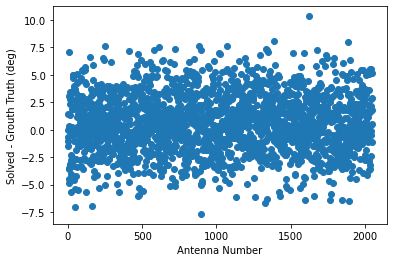

In [36]:
plt.plot((dppp_solved - ans) * 57.2958, linestyle='None', marker='o')
plt.ylabel('Solved - Grouth Truth (deg)')
plt.xlabel('Antenna Number')

In [38]:
resid_dppp = (dppp_solved - ans) * 57.2958
print(np.mean(resid_dppp))
print(np.std(resid_dppp))

0.64500841500783
2.639683771271592


# Did I get it right?

In [23]:
from casacore.tables import table
import numpy as np

In [2]:
with table('/fastpool/data/W-snapshot-8000chan.ms') as t:
    first_row = t.getcol('DATA',nrow=1)

Successful readonly open of default-locked table /fastpool/data/W-snapshot-8000chan.ms: 22 columns, 2096128 rows


In [3]:
first_row

array([[[0.99953777+0.03040166j, 0.        +0.j        ,
         0.        +0.j        , 0.99953777+0.03040166j],
        [0.999538  +0.0303946j , 0.        +0.j        ,
         0.        +0.j        , 0.999538  +0.0303946j ],
        [0.9995382 +0.03038755j, 0.        +0.j        ,
         0.        +0.j        , 0.9995382 +0.03038755j],
        ...,
        [0.9999433 +0.01064461j, 0.        +0.j        ,
         0.        +0.j        , 0.9999433 +0.01064461j],
        [0.9999434 +0.01064375j, 0.        +0.j        ,
         0.        +0.j        , 0.9999434 +0.01064375j],
        [0.9999434 +0.01064288j, 0.        +0.j        ,
         0.        +0.j        , 0.9999434 +0.01064288j]]],
      dtype=complex64)

In [7]:
np.angle(first_row[0,:,0])

array([0.03040634, 0.03039929, 0.03039223, ..., 0.01064481, 0.01064395,
       0.01064308], dtype=float32)

In [25]:
iono_gains[0, 0] * np.conj(iono_gains[1, 0]).T

array([[0.99953776+0.03040166j, 0.        +0.j        ],
       [0.        +0.j        , 0.99953776+0.03040166j]])

In [24]:
iono_gains[1, 0]

array([[0.97422214-0.22559084j, 0.        +0.j        ],
       [0.        +0.j        , 0.97422214-0.22559084j]])

In [31]:
with table('/fastpool/data/W-snapshot-8000chan.ms') as t:
    row = t.getcol('DATA',64000, 1)
    ant1 = t.getcol('ANTENNA1',64000, 1)
    ant2 = t.getcol('ANTENNA2',64000, 1)

Successful readonly open of default-locked table /fastpool/data/W-snapshot-8000chan.ms: 22 columns, 2096128 rows


In [32]:
ant1

array([31], dtype=int32)

In [33]:
ant2

array([1040], dtype=int32)

In [34]:
iono_gains[31, 0] * np.conj(iono_gains[1040, 0]).T

array([[0.9577781-0.28750845j, 0.       +0.j        ],
       [0.       +0.j        , 0.9577781-0.28750845j]])

In [35]:
row

array([[[0.9577781 -0.28750846j, 0.        +0.j        ,
         0.        +0.j        , 0.9577781 -0.28750846j],
        [0.9577976 -0.28744364j, 0.        +0.j        ,
         0.        +0.j        , 0.9577976 -0.28744364j],
        [0.957817  -0.28737882j, 0.        +0.j        ,
         0.        +0.j        , 0.957817  -0.28737882j],
        ...,
        [0.994793  -0.10191618j, 0.        +0.j        ,
         0.        +0.j        , 0.994793  -0.10191618j],
        [0.99479383-0.10190792j, 0.        +0.j        ,
         0.        +0.j        , 0.99479383-0.10190792j],
        [0.99479467-0.10189967j, 0.        +0.j        ,
         0.        +0.j        , 0.99479467-0.10189967j]]],
      dtype=complex64)

In [37]:
iono_gains[31, -1] * np.conj(iono_gains[1040, -1]).T

array([[0.99479468-0.10189967j, 0.        +0.j        ],
       [0.        +0.j        , 0.99479468-0.10189967j]])

In [21]:
dftsource.point_src_with_gain(iono_gains, '/fastpool/data/W-snapshot-8000chan.ms', rms=0.366268)

[                                        ] | 1% Completed |  2.9s


KeyboardInterrupt: 

# What happens time x later?

In [20]:
tec_screens.shape

(2048, 277, 1)

In [21]:
offsets.lon.max()

<Angle 1.52348605 deg>

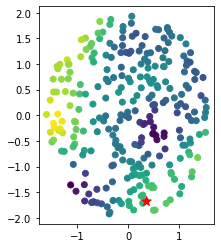

In [22]:
plt.scatter(offsets.lon, offsets.lat, c=tec_screens[0])
plt.scatter(offsets.lon[30], offsets.lat[30], marker='*', s=100, color='red')
plt.gca().set_aspect(1)

In [25]:
np.cos(offsets.lat)

<Quantity [0.99999281, 0.99999939, 0.99972701, 0.99999831, 0.99992658,
           0.99971224, 0.99978984, 0.99966553, 0.99991758, 0.99999505,
           0.99998705, 0.99969501, 0.99979627, 0.99997997, 0.99999001,
           0.99985656, 0.99998284, 0.99999997, 0.99978   , 0.99999339,
           0.99999657, 0.9999707 , 0.99964182, 0.99998832, 0.99974324,
           0.99963106, 0.99952731, 0.99988037, 0.99997781, 0.99945511,
           0.99957369, 0.99956615, 0.99996877, 0.99969703, 0.99968218,
           0.9994361 , 0.99985754, 0.99994807, 0.99999847, 0.99969503,
           0.99959996, 0.99997863, 0.99994829, 0.99999999, 0.99990372,
           0.99991497, 0.99965113, 0.99986304, 0.9997755 , 0.99992433,
           0.99998683, 0.99987144, 0.99995873, 0.99993493, 0.9999576 ,
           0.99988838, 0.99992439, 0.99987505, 0.99986015, 0.99990944,
           0.99992602, 0.99999811, 0.99977336, 0.99999758, 0.99980992,
           0.9995454 , 0.99985613, 0.99977826, 0.9999773 , 0.9999835 ,
      

So we'll move to the upper right corner.

In [12]:
HEIGHT = 300 * u.km
SPEED = 72 * (u.km/u.hour)

Text(0.5, 1.0, 'in km')

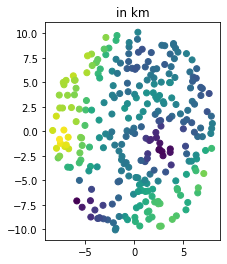

In [27]:
plt.scatter(np.sin(offsets.lon) * HEIGHT, np.sin(offsets.lat) * HEIGHT, c=tec_screens[0])
plt.gca().set_aspect(1)
plt.title('in km')

1. Calculate offset vector
2. add to antenna coords
3. interpolate

In [13]:
time_steps_s = np.linspace(0, 900, 1200)

In [14]:
time_steps_s

array([0.00000000e+00, 7.50625521e-01, 1.50125104e+00, ...,
       8.98498749e+02, 8.99249374e+02, 9.00000000e+02])

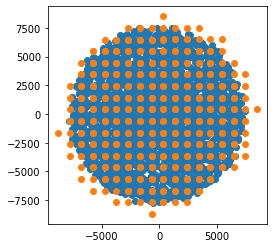

In [36]:
plt.scatter(actual_ants[:,0], actual_ants[:,1])
plt.scatter(antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
            antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value)))
plt.gca().set_aspect(1)

In [15]:
start_coord = np.array([0, -7500])

In [16]:
offset_vecs = time_steps_s[:, None] * np.array([0, SPEED.to(u.m/u.s).value])

In [17]:
coords = offset_vecs + start_coord

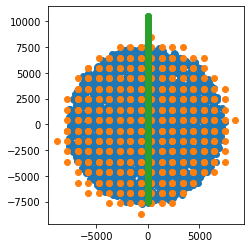

In [18]:
plt.scatter(actual_ants[:,0], actual_ants[:,1])
plt.scatter(antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
            antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value)))
plt.scatter(coords[:,0], coords[:,1])
plt.gca().set_aspect(1)

In [19]:
tec_screens = griddata((antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
                        antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value))),
                       np.swapaxes(tec_grid, 0, 1),
                       coords, method='linear')

Text(0.5, 1.0, '700MHz')

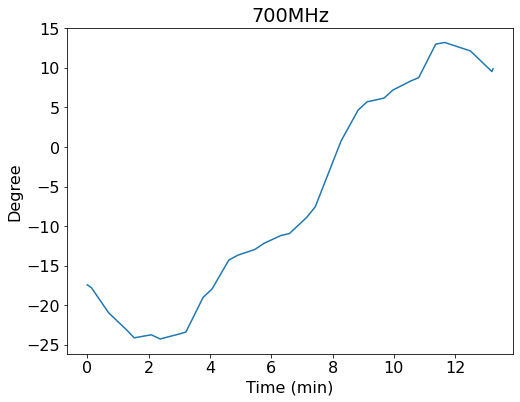

In [21]:
plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = '16'
plt.plot(time_steps_s/60, tec_screens[:,30,0]*(TEC_CONV * 1e6 /0.7e9) * 57.2958)
plt.xlabel('Time (min)')
plt.ylabel('Degree')
plt.title('700MHz')

# GPGPGP

In [6]:
tec_grid.shape

(277, 390, 1)

In [10]:
X = np.array((antennas_grid_enu.east.value, antennas_grid_enu.north.value))
y = tec_grid[30,:,0]

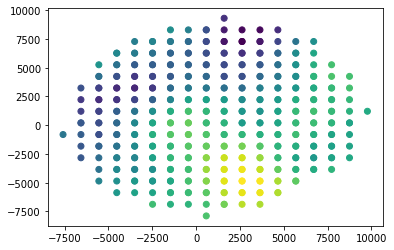

In [8]:
plt.scatter(X[0], X[1], c=y)

In [82]:
y.max()

41.07209749971669

In [83]:
y.min()

-26.802587326500095

In [100]:
y.std()

15.141677099196007

In [302]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, DotProduct, RationalQuadratic, Matern, ConstantKernel as C
# kk = C(0.3, [0.001, 1]) * ExpSineSquared(length_scale=2e4, periodicity=2500, periodicity_bounds=[1000, 10000], length_scale_bounds=[1e4,5e7]) + C(2, [1, 20]) * RBF(length_scale=17000, length_scale_bounds=(5000, 4e6)) + WhiteKernel(0.01)
# kk = C(0.3, [0.01, 1]) * RBF(length_scale=2500, length_scale_bounds=(500, 5000)) + C(2, [1, 20]) * RBF(length_scale=17000, length_scale_bounds=(5000, 4e6)) + WhiteKernel(0.01)
"""
kk = C(0.3, [0.001, 1]) * RBF(length_scale=2500, length_scale_bounds=(500, 5000)) * ExpSineSquared(length_scale=2e4, periodicity=2500, periodicity_bounds=[1000, 10000]) + \
        C(2, [1, 20]) * RBF(length_scale=17000, length_scale_bounds=(5000, 4e6)) + \
        WhiteKernel(0.01)
"""
kk = C(0.3, [0.001, 1]) * RationalQuadratic(length_scale=1e4) * ExpSineSquared(length_scale=2e4, periodicity=2500, periodicity_bounds=[1000, 10000]) + \
        C(1) * RationalQuadratic(length_scale=1e4) * ExpSineSquared(length_scale=8e4, periodicity=12500, periodicity_bounds=[1e4, 2e5]) + \
        C(2, [0.001, 20]) * RationalQuadratic(length_scale=17000, length_scale_bounds=(5000, 8e6)) + \
        C(2, [0.001, 20]) * RationalQuadratic(length_scale=17000, length_scale_bounds=(5000, 8e6)) + \
        WhiteKernel(0.01)
"""
kk = C(0.3, [0.001, 1]) * ExpSineSquared(length_scale=2e4, periodicity=2500, periodicity_bounds=[1000, 75000], length_scale_bounds=[1e3,5e7]) + \
        C(0.3, [0.001, 1]) * ExpSineSquared(length_scale=1e8, periodicity=10000, periodicity_bounds=[7500, 20000], length_scale_bounds=[1e7,1e9]) + \
        C(2, [1, 20]) * RBF(length_scale=17000, length_scale_bounds=(5000, 4e6)) + \
        WhiteKernel(0.01)
"""
gpr = GaussianProcessRegressor(kernel=kk, normalize_y=True, n_restarts_optimizer=30).fit(X.T, y)

In [301]:
gpr.kernel_

0.056**2 * RationalQuadratic(alpha=1.17, length_scale=1.6e+03) * ExpSineSquared(length_scale=0.826, periodicity=2.71e+03) + 0.724**2 * RationalQuadratic(alpha=2.17, length_scale=2.34e+03) * ExpSineSquared(length_scale=8.36e+04, periodicity=1.05e+05) + 0.557**2 * RationalQuadratic(alpha=5.36e+03, length_scale=5.75e+03) + 0.349**2 * RationalQuadratic(alpha=1.31, length_scale=2.43e+05) + WhiteKernel(noise_level=0.000165)

In [304]:
xy_grid = np.mgrid[-20000:20000:100j, -20000:20000:100j]

In [305]:
xy_grid.reshape(2, -1).shape

(2, 10000)

/home/yuping/.local/share/virtualenvs/frank-1tGSZLq3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:475: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


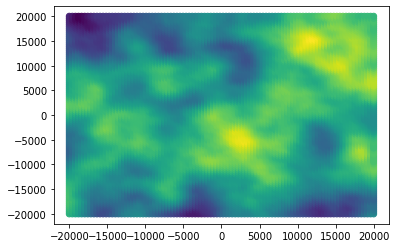

In [306]:
# y_pred, y_pred_unc = gpr.predict(xy_grid.reshape(2, -1).T, return_std=True)
y_sample = gpr.sample_y(xy_grid.reshape(2, -1).T)
plt.scatter(xy_grid[0].flatten(), xy_grid[1].flatten(), c=y_sample)

In [308]:
np.savez('/safepool/yuping/fudged-iono.npz', xy=xy_grid, tec=y_sample)

In [309]:
np.std(y_sample)

18.53708542246332

In [310]:
np.std(y)

15.141677099196007

In [168]:
y_pred

array([8.16781725, 8.11674701, 8.0559406 , ..., 7.30648259, 7.44000233,
       7.56669671])

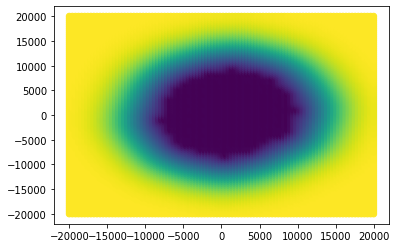

In [195]:
plt.scatter(xy_grid[0].flatten(), xy_grid[1].flatten(), c=y_pred_unc.T)

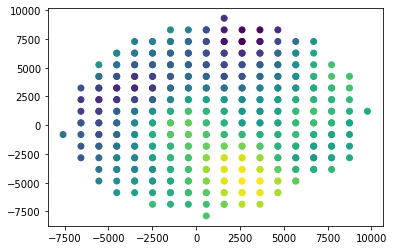

In [140]:
plt.scatter(X[0], X[1], c=gpr.predict(X.T))

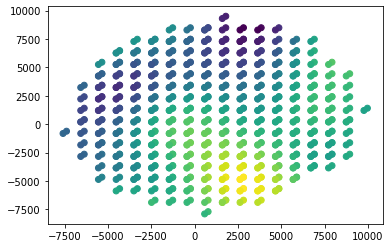

In [161]:
plt.scatter(X[0]+200, X[1]+200, c=gpr.predict((X+200).T))
plt.scatter(X[0], X[1], c=gpr.predict(X.T))

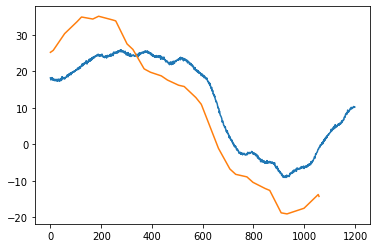

In [307]:
plt.plot(gpr.sample_y(coords))
plt.plot(tec_screens[:,30,0])

# Try a Fourier thing since GP regress to the mean outside the data

In [258]:
lim = 7600/np.sqrt(2)
sq_xy = np.mgrid[-lim:lim:100j, -lim:lim:100j]
sq_tec = griddata((antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
                        antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value))),
                       tec_grid[30,:,0],
                       sq_xy.reshape(2,-1).T, method='linear')

In [260]:
np.any(np.isnan(sq_tec))

False

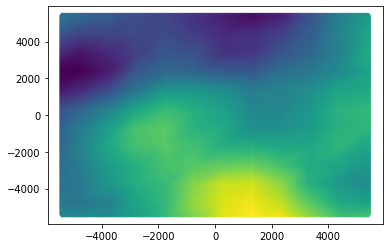

In [259]:
plt.scatter(sq_xy[0], sq_xy[1], c=sq_tec)

In [261]:
sq_tec_grid = sq_tec.reshape(100, 100)

In [262]:
from numpy import fft
tec_ft = fft.fft2(sq_tec_grid)

In [263]:
tec_ft.shape

(100, 100)

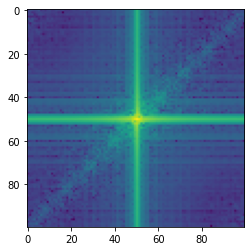

In [264]:
plt.imshow(np.log(np.abs(fft.fftshift(tec_ft))))

In [229]:
np.abs(tec_ft).max()

73983.41956590224

In [230]:
np.abs(tec_ft).min()

0.3579882477423949

## smaller number of channels

In [23]:
freq_arr = (np.arange(32) * 134e3) + 1.35e9
iono_gains_smol = np.exp(1j * tec_screens[:,30, None, None] * (TEC_CONV * 1e6 /freq_arr)[None, :, None, None]) * np.identity(2)

In [12]:
iono_gains_smol.shape

(2048, 32, 2, 2)

In [24]:
iono_gains_smol = np.tile(iono_gains_smol, (7,1, 1, 1, 1))

In [25]:
iono_gains_smol.shape

(7, 2048, 32, 2, 2)

In [27]:
import dftsource
import importlib
importlib.reload(dftsource)
dftsource.point_src_with_gain(iono_gains_smol, '/fastpool/data/W-32chan-10s.ms', rms=9.88007)

14672896
[########################################] | 100% Completed | 489.39 s


In [31]:
np.save('/fastpool/data/W-32chan-10-5s-gain.npy', iono_gains_smol)